In [1]:
import os, sys
import tarfile, glob
os.environ['R_HOME'] = sys.exec_prefix + '/lib/R/'
import numpy as np
import scanpy as sc
import scanpy.external as sce
import scFates as scf
import anndata as ad
import matplotlib.pyplot as plt

In [2]:
geo = 'GSE162534'
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_unzip = os.path.join(pth_data, 'unzip', geo)
pth_out = os.path.join(pth_data, 'processed')
pth_fig = os.path.join(pth, 'figures', 'preprocessing', 'processed')

In [3]:
samples = sorted(os.listdir(pth_unzip))
adata_dict = {fn.replace('.tar.gz', '') : fn for fn in samples if 'velo' not in fn}
for key in adata_dict:
    with tarfile.open(os.path.join(pth_unzip, adata_dict[key]), 'r:gz') as tar:
        tar.extractall(path = os.path.join(pth_unzip, key))
    _pth_ = glob.glob(os.path.join(pth_unzip, key, '*', '*', '*', '*'))[0]
    adata_dict[key] = sc.read_10x_mtx(_pth_)
adata = ad.concat(adata_dict, label = 'sample')
adata.obs_names_make_unique(); adata

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 5898240 × 27998
    obs: 'sample'

In [4]:
sc.pp.filter_cells(adata, min_genes = 1000)
adata

AnnData object with n_obs × n_vars = 11366 × 27998
    obs: 'sample', 'n_genes'

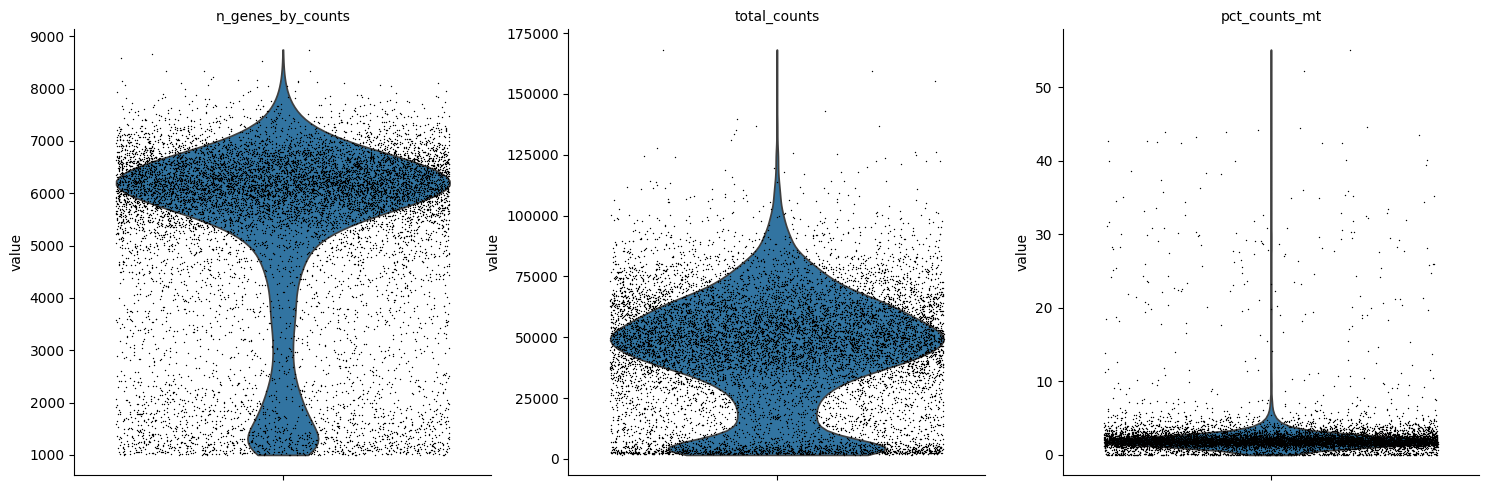

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, inplace = True, log1p = False)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter = .4, multi_panel = True)

In [6]:
adata = adata[
    (adata.obs.total_counts <= 125000) &
    (adata.obs.total_counts >= 25000) &
    (adata.obs.pct_counts_mt <= 8)]
adata

View of AnnData object with n_obs × n_vars = 8897 × 27998
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [7]:
sc.pp.normalize_total(adata, target_sum = 50000)
sc.pp.log1p(adata)

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Finding overdispersed features
    computing mean and variances
    gam fitting
    found 3875 over-dispersed features (0:00:02) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



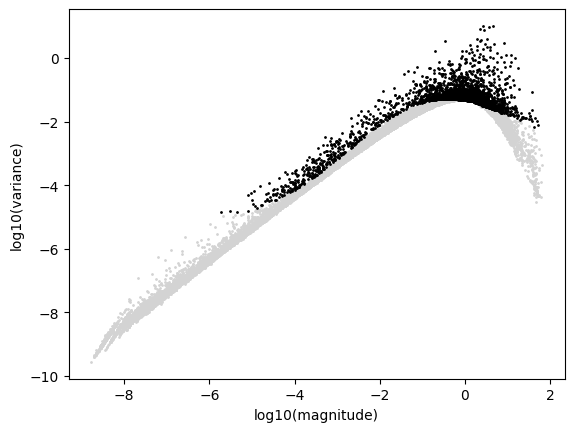

In [8]:
sc.pp.filter_genes(adata, min_cells = 3)
scf.pp.find_overdispersed(adata, plot = True)

In [48]:
sc.pp.pca(adata)
sce.pp.harmony_integrate(adata, 'sample')

2025-10-13 00:49:14,799 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-13 00:49:17,594 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-13 00:49:17,690 - harmonypy - INFO - Iteration 1 of 10
2025-10-13 00:49:21,630 - harmonypy - INFO - Iteration 2 of 10
2025-10-13 00:49:25,531 - harmonypy - INFO - Iteration 3 of 10
2025-10-13 00:49:29,484 - harmonypy - INFO - Iteration 4 of 10
2025-10-13 00:49:31,965 - harmonypy - INFO - Converged after 4 iterations


In [176]:
sc.pp.neighbors(adata, use_rep = 'X_pca_harmony')
sc.tl.umap(adata, spread = .2)
sc.tl.leiden(adata)

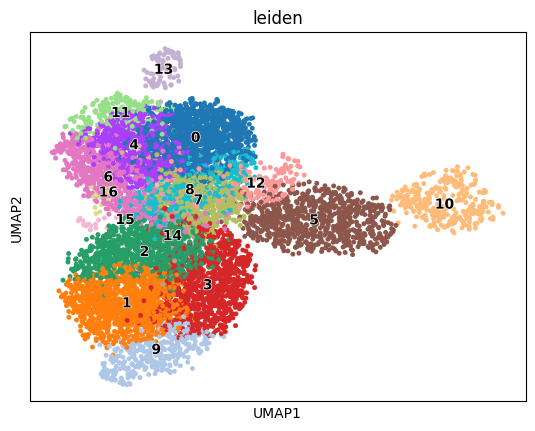

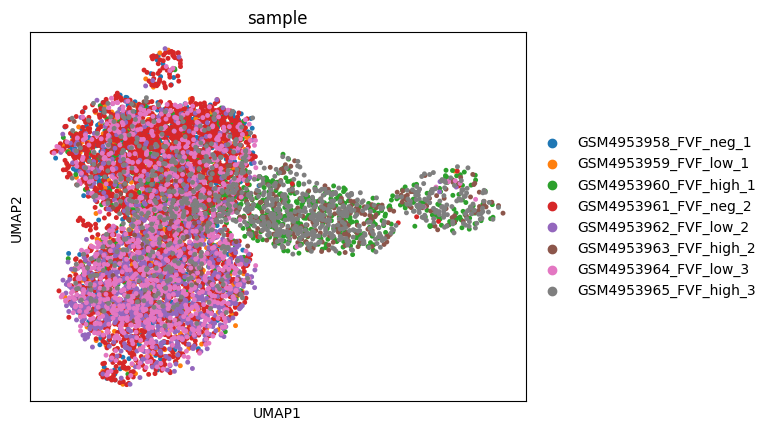

In [177]:
sc.pl.umap(adata, color = 'leiden', size = 50, legend_loc = 'on data', legend_fontoutline = True)
sc.pl.umap(adata, color = 'sample', size = 50)

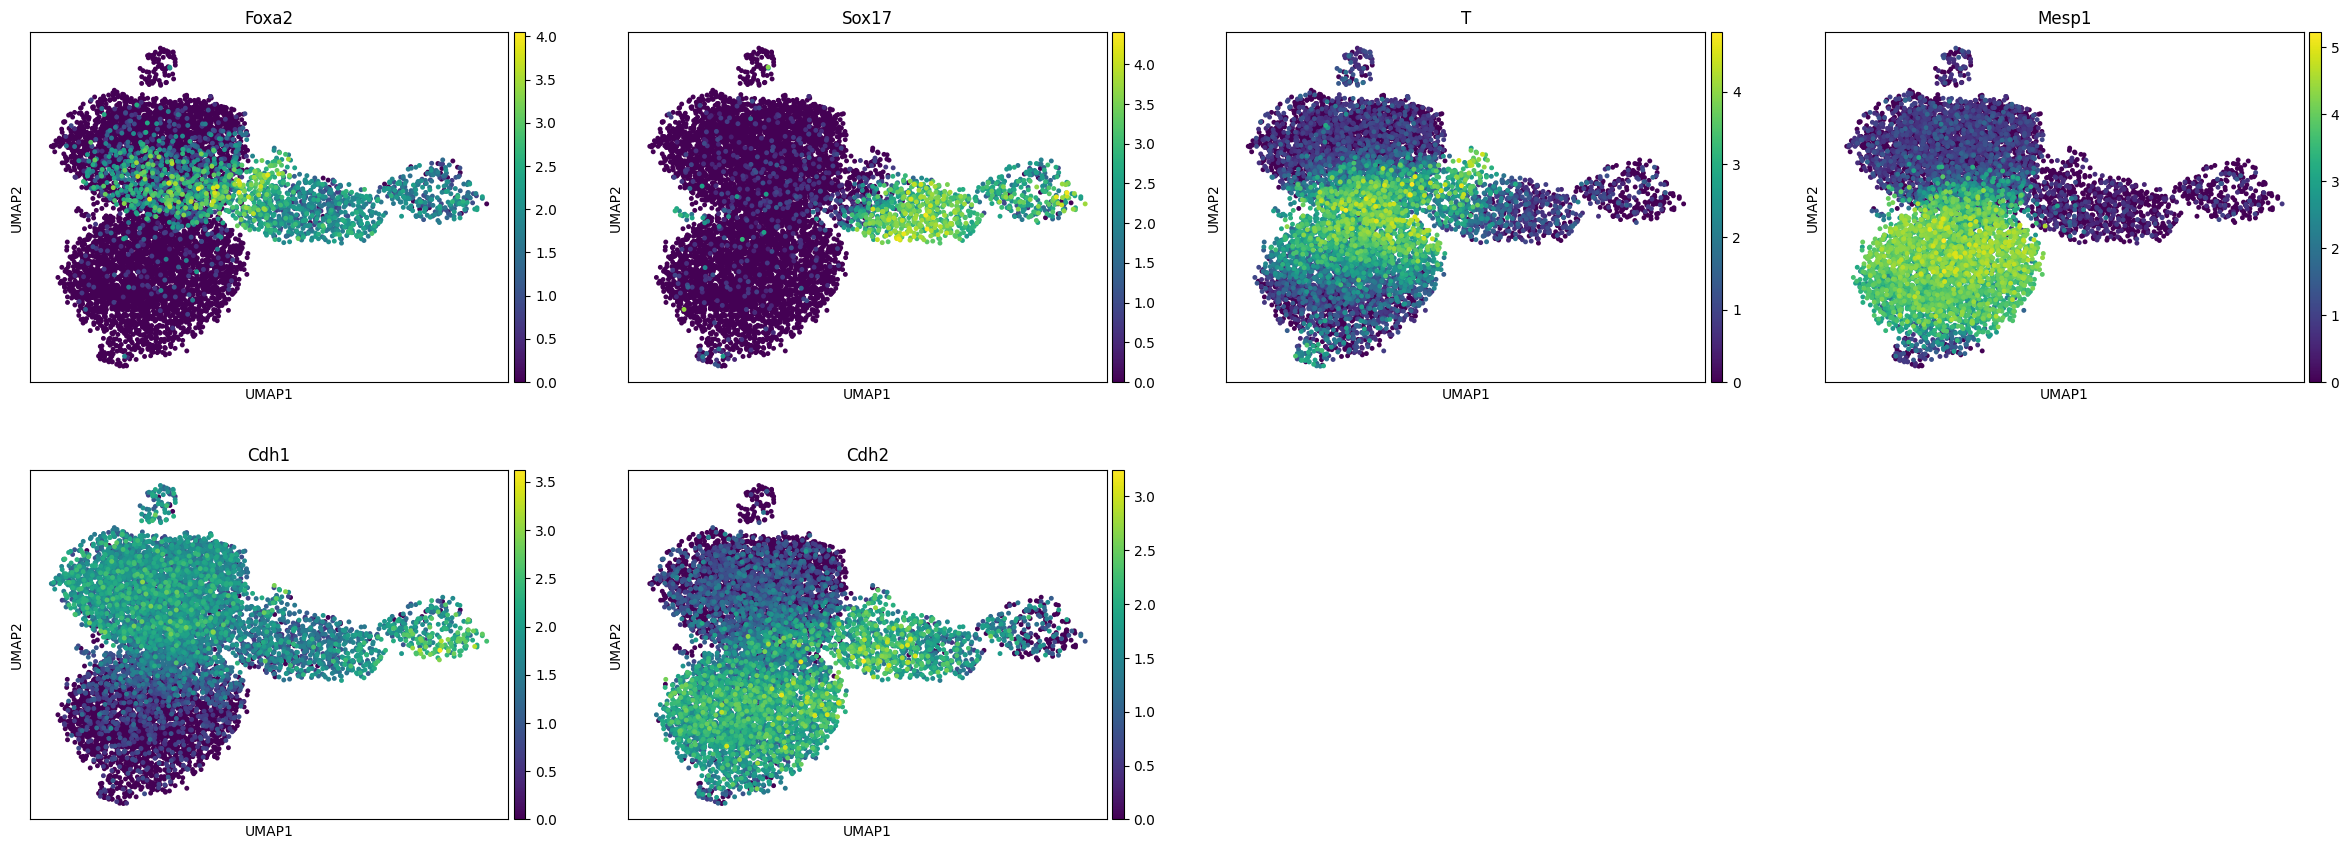

In [178]:
sc.pl.umap(adata, color = ['Foxa2', 'Sox17', 'T', 'Mesp1', 'Cdh1', 'Cdh2'], size = 50)

In [ ]:
remove = np.array([17, 13, 1, 11, 12], dtype = str)
adata = adata[~adata.obs.leiden.isin(remove), :]

In [ ]:
adata

In [ ]:
sc.pp.filter_genes(adata, min_cells = 3)
scf.pp.find_overdispersed(adata, plot = True)

In [ ]:
sc.pp.pca(adata)
sce.pp.harmony_integrate(adata, 'sample')

In [ ]:
sc.pp.neighbors(adata, n_pcs = 30, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = .2)

In [ ]:
sc.pl.umap(adata, color = 'leiden', size = 50, legend_loc = 'on data', legend_fontoutline = True)
sc.pl.umap(adata, color = 'sample', size = 50)
sc.pl.umap(adata, color = ['Foxa2', 'Sox17', 'T', 'Mesp1', 'Cdh1', 'Cdh2'], size = 50)

In [ ]:
celltype_dict = {
    '0' : 'Posterior Epiblast',
    '1' : 'Lateral Plate Mesoderm',
    '2' : 'Definitive Endoderm'
    }
adata.obs['celltype'] = adata.obs.leiden.map(celltype_dict).astype('category')

In [ ]:
sc.pl.umap(adata, color = 'celltype', size = 50)

In [ ]:
outdir = os.path.join('..', '..', 'data', 'processed')
adata.write(os.path.join(outdir, f'{geo}.h5ad'))